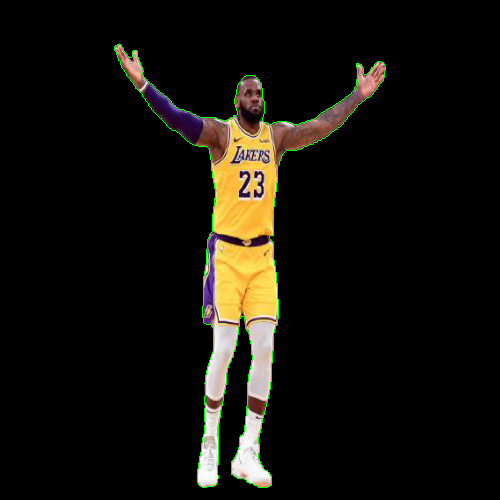

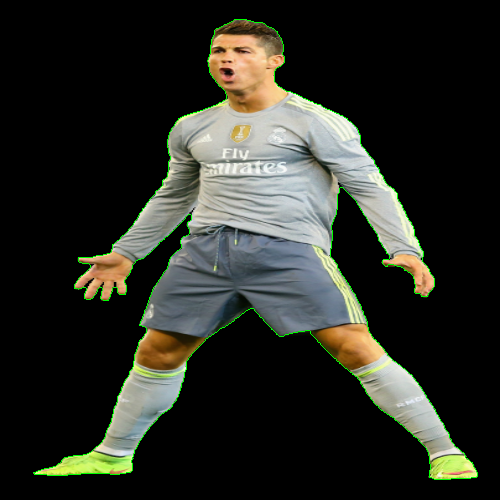

In [106]:
import numpy as np
import cv2
from PIL import Image 
from google.colab.patches import cv2_imshow

# Parameters
blur = 21
canny_low = 30
canny_high = 200
inWidth = 500
inHeight = 500

inputImageName = "./drive/MyDrive/PoseProject/lbj.png"
refImageName = "./drive/MyDrive/PoseProject/cr.png"
#refImageName = "jo4.png"

def getContourPoints(imageName):
  inputImage = cv2.imread(imageName)
  inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))
  # Convert image to grayscale        
  image_gray = cv2.cvtColor(inputImageResize, cv2.COLOR_BGR2GRAY)
  # Apply Canny Edge Dection
  edges = cv2.Canny(image_gray, canny_low, canny_high)
  edges = cv2.dilate(edges, None)
  edges = cv2.erode(edges, None)
  # get the contours and their areas
  inputContours, hierarchy = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  inputMaxContour = inputContours[0]
  for contour in inputContours:
    if cv2.contourArea(contour) > cv2.contourArea(inputMaxContour):
      inputMaxContour = contour

  inputContourPoints = inputMaxContour[:, 0, :]
  for point in inputContourPoints:
    inputImageResize[point[1], point[0], 0] = 0
    inputImageResize[point[1], point[0], 1] = 255
    inputImageResize[point[1], point[0], 2] = 0

  cv2_imshow(inputImageResize) 

  return inputContourPoints

inputContourPoints = getContourPoints(inputImageName)
refContourPoints = getContourPoints(refImageName)

In [ ]:
# ###detect pose
# #0: head
# #1: chest
# #2: left shoulder
# #3: left elbow
# #4: left hand
# #5: right shoulder
# #6: right elbow
# #7: right hand
# #8: left waist
# #9: left knee
# #10: left foot
# #11: right waist
# #12: right knee
# #13: right foot

# protoFile = "./drive/MyDrive/PoseProject/pose_deploy_linevec.prototxt"
# weightsFile = "./drive/MyDrive/PoseProject/pose_iter_440000.caffemodel"

# nPoints = 14
# POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

# threshold = 0.01
# net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# def getPosePoints(imageName):
#   inputImage = cv2.imread(imageName)
#   inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))
#   inpBlob = cv2.dnn.blobFromImage(inputImageResize, 1.0 / 255, (inWidth, inHeight),
#                             (0, 0, 0), swapRB=False, crop=False)
#   net.setInput(inpBlob)
#   output = net.forward()

#   H = output.shape[2]
#   W = output.shape[3]

#   points = []
#   shouldSave = True
#   for i in range(nPoints):
#       # confidence map of corresponding body's part.
#       probMap = output[0, i, :, :]

#       # Find global maxima of the probMap.
#       minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)

#       #print("%d and %d" % (point[1], point[0]))
#       if prob > threshold : 
#           hh = int(point[1] * inHeight / H)
#           ww = int(point[0] * inWidth / W)
#           points.append((ww, hh))
#           #print(hh, ww)
#           inputImageResize[hh, ww, :] = (0, 255, 0)
#           inputImageResize[hh+1, ww, :] = (0, 255, 0)
#           inputImageResize[hh, ww+1, :] = (0, 255, 0)
#           inputImageResize[hh+1, ww+1, :] = (0, 255, 0)

#       else :
#           print("Bad")
#           shouldSave = False
#           continue

#   cv2_imshow(inputImageResize)

#   lines = []
#   for pair in POSE_PAIRS:
#     indexStart = pair[0]
#     indexEnd = pair[1]
#     lines.append((points[indexStart], points[indexEnd]))

#   return lines

# inputPoseLines = getPosePoints(inputImageName)
# refPoseLines = getPosePoints(refImageName)


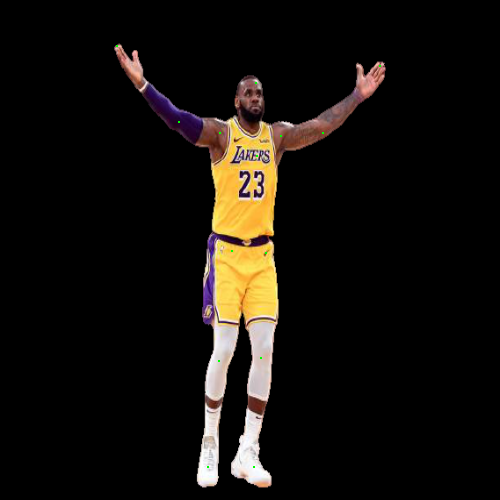

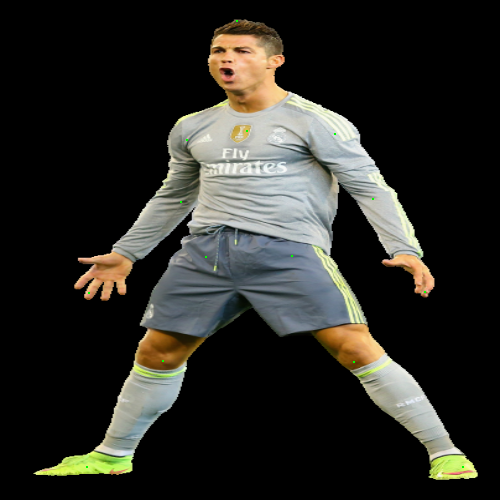

In [135]:
import math

# #0: head
# #1: chest
# #2: left shoulder
# #3: left elbow
# #4: left hand
# #5: right shoulder
# #6: right elbow
# #7: right hand
# #8: left waist
# #9: left knee
# #10: left foot
# #11: right waist
# #12: right knee
# #13: right foot
POSE_PAIRS = [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]

pointsLBJNormal = [
  (0.510,	0.164),
  (0.512,	0.311),
  (0.439,	0.264),
  (0.356,	0.242),
  (0.232,	0.090),
  (0.560,	0.271),
  (0.644,	0.264),
  (0.759,	0.13),
  (0.462,	0.5),
  (0.436,	0.721),
  (0.415,	0.933),
  (0.530,	0.504),
  (0.52,	0.714),
  (0.507,	0.933)]

pointsLBJ = []
inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))

for pair in pointsLBJNormal:
  wNormal, hNormal = pair
  ww = math.floor(wNormal * inWidth)
  hh = math.floor(hNormal * inHeight)
  pointsLBJ.append((ww, hh))
  inputImageResize[hh, ww, :] = (0, 255, 0)
  inputImageResize[hh+1, ww, :] = (0, 255, 0)
  inputImageResize[hh, ww+1, :] = (0, 255, 0)
  inputImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(inputImageResize)

pointsCRNormal = [
    (0.473,	0.04),
    (0.493,	0.261),
    (0.373,	0.278),
    (0.360,	0.402),
    (0.177,	0.584),
    (0.669,	0.266),
    (0.744,	0.397),
    (0.849,	0.582),
    (0.411,	0.513),
    (0.325,	0.721),
    (0.172,	0.933),
    (0.583,	0.511),
    (0.706,	0.723),
    (0.924,	0.933)      
]

pointsCR = []
refImage = cv2.imread("./drive/MyDrive/PoseProject/cr.png")
refImageResize = cv2.resize(refImage, (inWidth, inHeight))

for pair in pointsCRNormal:
  wNormal, hNormal = pair
  ww = math.floor(wNormal * inWidth)
  hh = math.floor(hNormal * inHeight)
  pointsCR.append((ww, hh))
  refImageResize[hh, ww, :] = (0, 255, 0)
  refImageResize[hh+1, ww, :] = (0, 255, 0)
  refImageResize[hh, ww+1, :] = (0, 255, 0)
  refImageResize[hh+1, ww+1, :] = (0, 255, 0)

cv2_imshow(refImageResize)

inputPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]

  inputPoseLines.append((pointsLBJ[indexStart], pointsLBJ[indexEnd]))
                              

refPoseLines = []
for pair in POSE_PAIRS:
  indexStart = pair[0]
  indexEnd = pair[1]

  refPoseLines.append((pointsCR[indexStart], pointsCR[indexEnd]))

0
1
2
3
4
5
6
7
8
9
10
11
12


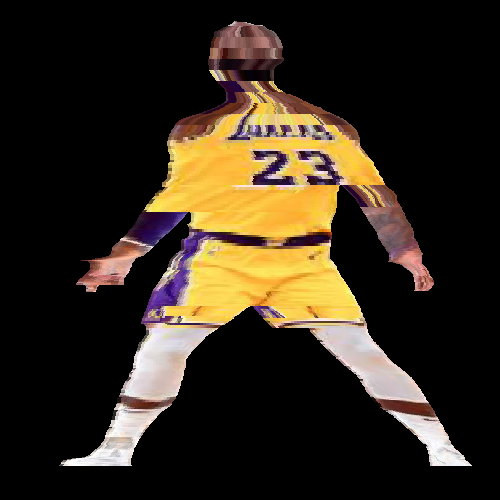

In [139]:
import numpy as np

def findLeftAndRight(contourPoints, targetPoint, startPoint, endPoint):
  w, h = targetPoint
  wStart, hStart = startPoint
  wEnd, hEnd = endPoint

  left = -1
  right = inWidth
  leftPoint = (-1, -1)
  rightPoint = (-1, -1)

  for point in contourPoints:
    wPoint, hPoint = point

    length1 = math.sqrt((hEnd - hStart) ** 2 + (wEnd - wStart) ** 2)
    length2 = math.sqrt((hPoint - h) ** 2 + (wPoint - w) ** 2)
    if length2 == 0:
      continue
    dotProduct = (hEnd - hStart) * (hPoint - h) + (wEnd - wStart) * (wPoint - w)
    angle = abs(np.arccos(dotProduct / length1 / length2))
    if abs(angle - math.pi / 2) < math.pi / 20:

      if point[0] < w and point[0] > left:
        left = point[0]
        leftPoint = point

      if point[0] > w and point[0] < right:
        right = point[0]
        rightPoint = point    

  if leftPoint[0] == -1 and leftPoint[1] == -1:
    leftPoint = targetPoint
  
  if rightPoint[0] == -1 and rightPoint[1] == -1:
    rightPoint = targetPoint

  return leftPoint, rightPoint

def findLeftAndRightOld(contourPoints, targetPoint):
  w, h = targetPoint
  left = -1
  right = inWidth

  for point in contourPoints:
    if abs(point[1] - h) < 3:

      if point[0] < w and point[0] > left:
        left = point[0]

      if point[0] > w and point[0] < right:
        right = point[0]

  if left == -1:
    left = w
  if right == inWidth:
    right = w

  return left, right

def getInterPolatePoints(pointStart, pointEnd):
  wStart, hStart = pointStart
  wEnd, hEnd = pointEnd

  points = []

  if abs(wStart - wEnd) > abs(hStart - hEnd):
    step =  1 if wStart < wEnd else -1

    for w in range(wStart, wEnd, step):
      k = (w - wStart) / (wEnd - wStart)
      h = round(hStart + k * (hEnd - hStart))
      points.append((w, h))
  else:
    step =  1 if hStart < hEnd else -1

    for h in range(hStart, hEnd, step):
      k = (h - hStart) / (hEnd - hStart)
      w = round(wStart + k * (wEnd - wStart))
      points.append((w, h))

  return points

workImage = np.zeros((inHeight, inWidth, 3), dtype = np.uint8)
inputImage = cv2.imread("./drive/MyDrive/PoseProject/lbj.png")
inputImageResize = cv2.resize(inputImage, (inWidth, inHeight))

inputContourPointsRefine = []
for i in range(0, len(inputContourPoints) - 1):
  for point in getInterPolatePoints(inputContourPoints[i], inputContourPoints[i+1]):
    inputContourPointsRefine.append(point)

refContourPointsRefine = []
for i in range(0, len(refContourPoints) - 1):
  for point in getInterPolatePoints(refContourPoints[i], refContourPoints[i+1]):
    refContourPointsRefine.append(point)

skeletonList = [0, 1, 2, 3, 5, 7, 8, 10, 11]
# #0: head
# #1: chest
# #2: left shoulder
# #3: left elbow
# #4: left hand
# #5: right shoulder
# #6: right elbow
# #7: right hand
# #8: left waist
# #9: left knee
# #10: left foot
# #11: right waist
# #12: right knee
# #13: right foot
# [ [1,0],[1,2],[1,5],[2,3],[3,4],[5,6],[6,7],[1,8],[8,9],[9,10],[1,11],[11,12],[12,13]]
# for i in range(len(inputPoseLines)):
#   print(i)
#   if i in [0, 1, 2, 3, 5, 7, 10]:
#     continue

#   inputLine = inputPoseLines[i]
#   refLine = refPoseLines[i]
#   pointStart1, pointEnd1 = inputLine
#   pointStart2, pointEnd2 = refLine

#   wStartInput, hStartInput = pointStart1
#   wEndInput, hEndInput = pointEnd1
#   wStartRef, hStartRef = pointStart2
#   wEndRef, hEndRef = pointEnd2

#   pointsInterpolateRef = getInterPolatePoints(pointStart2, pointEnd2)

#   for point in pointsInterpolateRef:
#     wRef, hRef = point
#     leftPointRef, rightPointRef = findLeftAndRight(refContourPointsRefine, (wRef, hRef), pointStart2, pointEnd2)
#     wLeftRef, hLeftRef = leftPointRef
#     wRightRef, hRightRef = rightPointRef

#     if hEndRef == hStartRef and wStartRef == wEndRef:
#       continue

#     if wStartRef == wEndRef: 
#       kRef = (hRef - hStartInput) / (hEndRef - hStartRef)
#     else:
#       kRef = (wRef - wStartRef) / (wEndRef - wStartRef)

#     wInput = wStartInput + round(kRef * (wEndInput - wStartInput))
#     hInput = hStartInput + round(kRef * (hEndInput - hStartInput))
#     leftInputPoint, rightInputPoint = findLeftAndRight(inputContourPointsRefine, (wInput, hInput), pointStart1, pointEnd1)
#     wLeftInput, hLeftInput = leftInputPoint
#     wRightInput, hRightInput = rightInputPoint

#     pointsInterpolateRef2 = getInterPolatePoints(leftPointRef, rightPointRef)
#     for point in pointsInterpolateRef2:
#       ww, hh = point
#       if abs(wRightRef - wLeftRef) > (hRightRef - hLeftRef):
#         kInput = abs(ww - wLeftRef) / abs(wRightRef - wLeftRef)
#         wThing = int(wLeftInput * (1 - kInput) + wRightInput * kInput)
#         hThing = int(hLeftInput * (1 - kInput) + hRightInput * kInput)

#         workImage[hh, ww] = inputImageResize[hThing, wThing]
#       else:
#         kInput = abs(hh - hLeftRef) / abs(hRightRef - hLeftRef)
#         wThing = int(wLeftInput * (1 - kInput) + wRightInput * kInput)
#         hThing = int(hLeftInput * (1 - kInput) + hRightInput * kInput)

#         workImage[hh, ww] = inputImageResize[hThing, wThing]

# cv2_imshow(workImage)

for i in range(len(inputPoseLines)):
  print(i)
  # if i not in skeletonList:
  #   continue

  inputLine = inputPoseLines[i]
  refLine = refPoseLines[i]
  pointStart1, pointEnd1 = inputLine
  pointStart2, pointEnd2 = refLine

  wStartInput, hStartInput = pointStart1
  wEndInput, hEndInput = pointEnd1
  wStartRef, hStartRef = pointStart2
  wEndRef, hEndRef = pointEnd2

  pointsInterpolateRef = getInterPolatePoints(pointStart2, pointEnd2)

  for point in pointsInterpolateRef:
    wRef, hRef = point
    wLeftRef, wRightRef = findLeftAndRightOld(refContourPointsRefine, (wRef, hRef))
    
    if hEndRef == hStartRef and wStartRef == wEndRef:
      continue

    if wStartRef == wEndRef: 
      kRef = (hRef - hStartInput) / (hEndRef - hStartRef)
    else:
      kRef = (wRef - wStartRef) / (wEndRef - wStartRef)

    wInput = wStartInput + round(kRef * (wEndInput - wStartInput))
    hInput = hStartInput + round(kRef * (hEndInput - hStartInput))
    wLeftInput, wRightInput = findLeftAndRightOld(inputContourPointsRefine, (wInput, hInput))

    for ww in range(wLeftRef, wRightRef):
      kInput = (ww - wLeftRef) / (wRightRef - wLeftRef)
      wThing = int(wLeftInput * (1 - kInput) + wRightInput * kInput)

      workImage[hRef, ww] = inputImageResize[hInput, wThing]

cv2_imshow(workImage) 

